In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)
measurement_col = inspector.get_columns('measurement')
station_col = inspector.get_columns('station')

print(f"measurement columns")
for c in measurement_col:
    print(c['name'], c["type"])
print(f"----------------------")
print(f"station columns")
for c in station_col:
    print(c['name'], c["type"])    

measurement columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------
station columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


2017-08-23
2017-08-23 00:00:00
2016-08-23


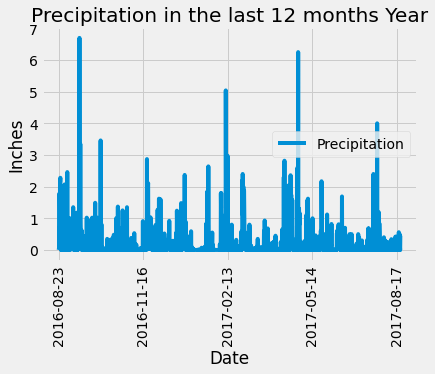

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date_string = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date_string[0])
latest_date=dt.datetime.strptime(latest_date_string[0],'%Y-%m-%d')
print(latest_date)

# Calculate the date 1 year ago from the last data point in the database
query_date=dt.date(latest_date.year -1, latest_date.month, latest_date.day)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Prcp_12months_df = pd.DataFrame(results, columns=['Date','Precipitation'])
Prcp_12months_df.set_index('Date', inplace=True)
Prcp_12months_df.dropna(how='any', inplace=True)
# Sort the dataframe by date
Prcp_12months_df.sort_values('Date', ascending=True, inplace=True)
Prcp_12months_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
ax = Prcp_12months_df.plot(rot=90);
ax.set_title("Precipitation in the last 12 months Year");
ax.set_ylabel("Inches");

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Prcp_12months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_act=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_act

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query_station=station_act[0][0]
print(query_station)
temp_describe=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
results = session.query(Measurement.station,*temp_describe).\
            filter(Measurement.station == query_station).all()
print(results)

USC00519281
[('USC00519281', 54.0, 85.0, 71.66378066378067)]


2017-08-18
2017-08-18 00:00:00
2016-08-18


Text(0, 0.5, 'Frequency')

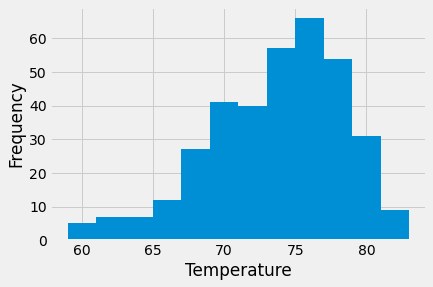

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

latest_date_str_stat = session.query(Measurement.date).\
                        filter(Measurement.station == query_station).\
                        order_by(Measurement.date.desc()).first()
print(latest_date_str_stat[0])
latest_date_stat=dt.datetime.strptime(latest_date_str_stat[0],'%Y-%m-%d')
print(latest_date_stat)

query_date_stat=dt.date(latest_date_stat.year -1, latest_date_stat.month, latest_date_stat.day)
print(query_date_stat)

results = session.query(Measurement.tobs).\
            filter(Measurement.date>query_date_stat).\
            filter(Measurement.station == query_station).all()
temp_results = list(np.ravel(results))
plt.hist(temp_results, bins=12,label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
